# Regressão Linear simples com Scikit-learn no dataset Ames Housing

## 1. Carregando as Bibliotecas e o Dataset

In [ ]:
# Importando as Bibliotecas necessárias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shashanknecrothapa/ames-housing-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ames-housing-dataset' dataset.
Path to dataset files: /kaggle/input/ames-housing-dataset


In [ ]:
import os
# Importando a base de dados do kaggle
df = pd.read_csv(os.path.join(path, "AmesHousing.csv"))

In [ ]:
df.head() # Verificando as 5 primeiras linhas do Dataset

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## 2. Realizando a EDA (Análise exploratória de Dados)
### Essa etapa é crucial no trabalho de regresão linear porque garante que o modelo seja treinado com dados confiável, além de permitir uma análise prévia dos dados disponível. Dessa maneira, garantindo compreenção e confiança nos dados.

In [ ]:
df.info() # tipos dos dados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [ ]:
df.shape # dimensões da Matriz

(2930, 82)

## 3. Limpeza e Tratamento de Valores Ausentes
### Essa etapa garante que a base de dados treine o modelo com valores válidos.

In [ ]:
# Identificar colunas com porcentagem de valores ausentes
missing_percentage = df.isnull().sum() / len(df) * 100

# Remover colunas com mais de 50% de valores ausentes
columns_to_drop_simple = missing_percentage[missing_percentage > 50].index.tolist()
df = df.drop(columns=columns_to_drop_simple, errors='ignore')
print(f"Colunas removidas (mais de 50% NaN): {columns_to_drop_simple}")

# Imputar valores numéricos com a mediana
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# Imputar valores categóricos com a moda
for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# Verificar se ainda há valores ausentes
remaining_missing = df.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]

if not remaining_missing.empty:
    print("\nValores ausentes restantes após a limpeza inicial:")
    display(remaining_missing)
else:
    print("\nTodos os valores ausentes foram tratados.")

# Verificando novamente o info para confirmar os tipos e ausentes
df.info()

Colunas removidas (mais de 50% NaN): ['Alley', 'Mas Vnr Type', 'Pool QC', 'Fence', 'Misc Feature']

Todos os valores ausentes foram tratados.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 77 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2930 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Lot Shape        2930 non-null   object 
 8   Land Contour     2930 non-null   object 
 9   Utilities        2930 non-null   object 
 10  Lot Config       2930 non-null   object 
 11  Land Slope       2930 non-null   object 
 12  Neighborhood     2930 non-null   object 
 13  Condition 1      2930 non-null   object 
 14  Condition 

## 4. Heatmap para visualiza a correlação das variáveis numéricas
### Mapa de calor no qual é possível verficar as correlações entre variáveis

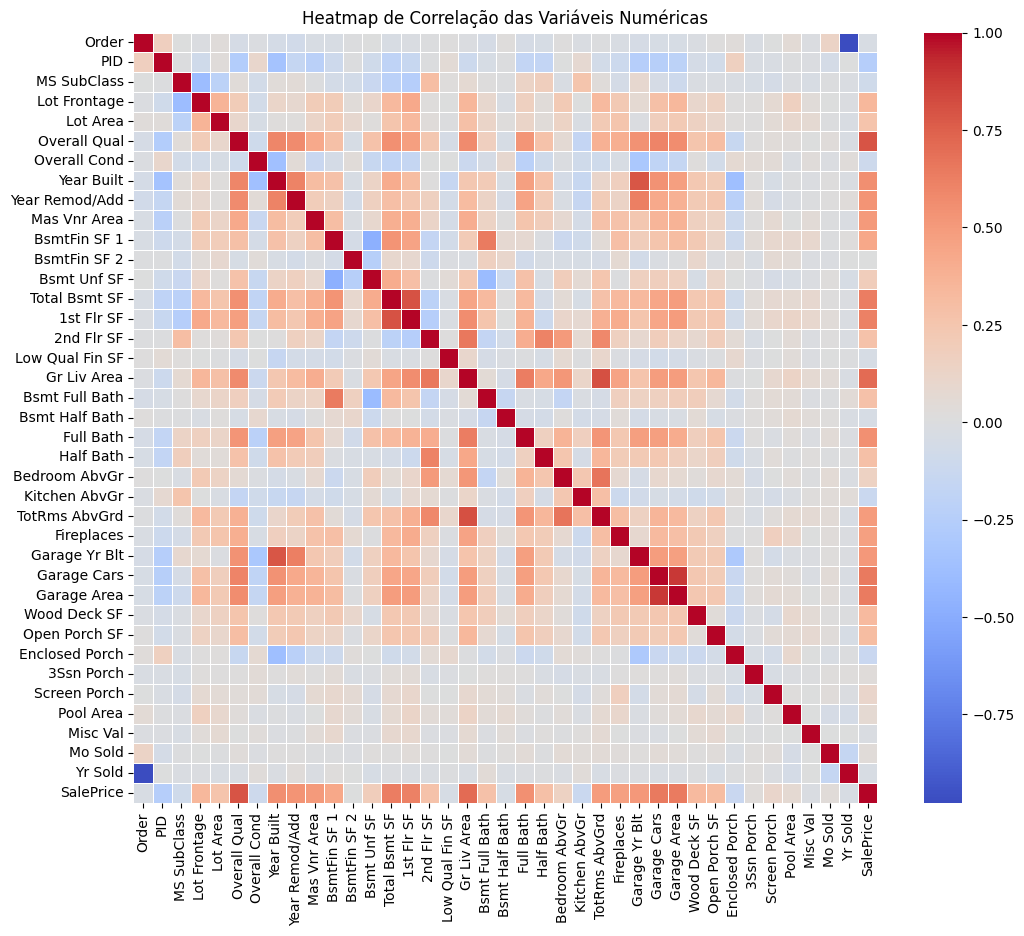

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', linewidths=.5)
plt.title('Heatmap de Correlação das Variáveis Numéricas')
plt.show()

## 5. Analisando as Correlações, Separando e Treinando o Modelo

### Durante essa etapa, com base no heatmap, foi possível selecionar as variáveis numéricas mais correlacionadas com o preço do imóvel (SalePrice). Em seguida, o conjunto de dados foi dividido em conjunto de treinamento e conjunto de teste. Posteriormente, o modelo foi criado e treinado utilizando a biblioteca Scikit-learn.

In [ ]:
# Selecionando as variáveis que estão mais correlacionadas baseadas no heatmap
features = ['Overall Qual', 'Gr Liv Area', 'Year Built', 'Garage Yr Blt', 'Garage Area', 'Garage Cars', 'TotRms AbvGrd']
X = df[features]
y = df['SalePrice']

In [ ]:
# Separando o conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Criando o modelo e treinando
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Predição do modelo
y_pred = modelo.predict(X_test)

## 6. Visualização da Regressão: Real vs Previsto

### Esse gráfico simples mostra a relação entre o preço real e o previsto pelo modelo.

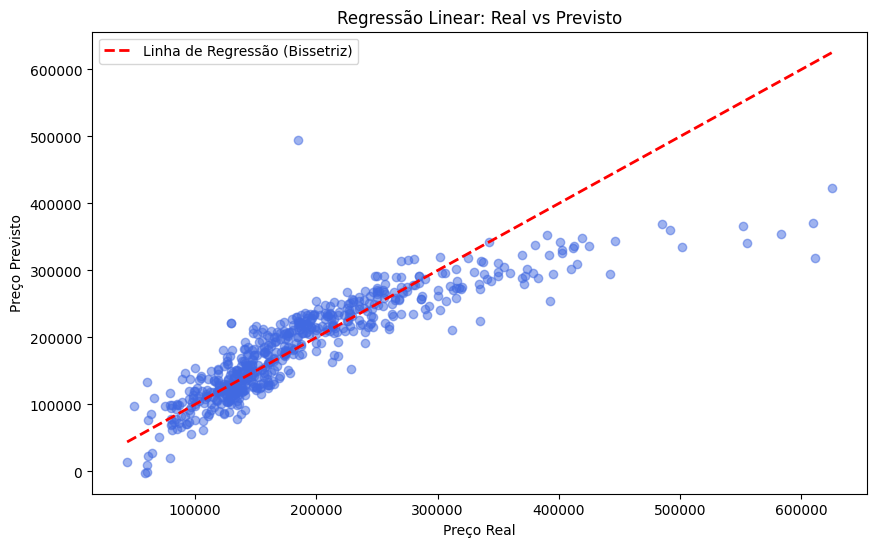

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Linha de Regressão (Bissetriz)')
plt.legend()
plt.xlabel('Preço Real')
plt.ylabel('Preço Previsto')
plt.title('Regressão Linear: Real vs Previsto')
plt.show()

## 7. Visualização da Regressão em relação a magnitude dos erros da Previsão
### Nesse plot é possível visualizar o tamanho do erro, isto é, o valor real subtraído do valor previsto no modelo.



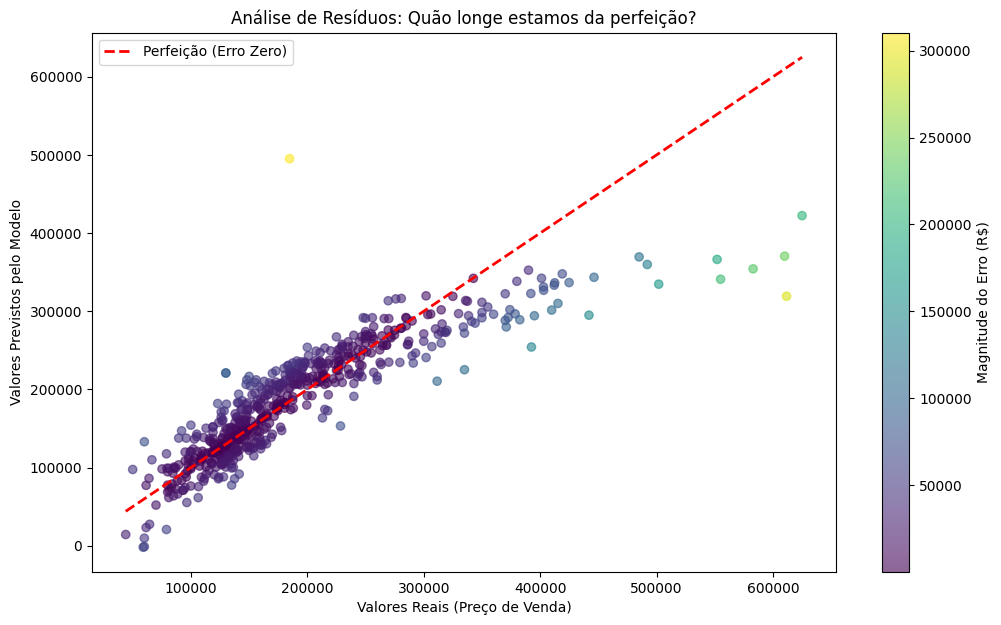

In [ ]:
# Calculando o erro absoluto para cada previsão
erros = np.abs(y_test - y_pred)

plt.figure(figsize=(12, 7))

# Criando o scatter plot onde a cor (c) depende do tamanho do erro
scatter = plt.scatter(y_test, y_pred, alpha=0.6, c=erros, cmap='viridis')

# Adicionando a linha de referência (Identidade)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         linestyle='--', color='red', lw=2, label='Perfeição (Erro Zero)')

# Adicionando uma barra de cores para legenda do erro
cbar = plt.colorbar(scatter)
cbar.set_label('Magnitude do Erro (R$)')

plt.xlabel('Valores Reais (Preço de Venda)')
plt.ylabel('Valores Previstos pelo Modelo')
plt.title('Análise de Resíduos: Quão longe estamos da perfeição?')
plt.legend()
plt.show()